<a href="https://colab.research.google.com/github/RastogiShlagha/Projects/blob/master/Structural_Breaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chow's Test

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("/content/financial_time_series.csv")
print(df.shape)
df.head()

(87, 3)


,Year,LogEqPrem,BookMarket
0,1927,0.280823,0.374689
1,1928,0.313824,0.259667
2,1929,-0.112428,0.338458
3,1930,-0.288025,0.554745
4,1931,-0.563742,1.170732


In [0]:
# Taking one set from (-)inf-->1980
x1 = df[df['Year'] < 1980]['BookMarket']
y1 = df[df['Year'] < 1980]['LogEqPrem']

# Taking another set from 1980-->(+)inf
x2 = df[df['Year'] >= 1980]['BookMarket']
y2 = df[df['Year'] >= 1980]['LogEqPrem']

In [8]:
!git clone https://github.com/jtloong/chow-test.git
%cd chow-test
!pip install .

Cloning into 'chow-test'...
remote: Enumerating objects: 108, done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (108/108), 24.47 KiB | 511.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/chow-test
Processing /content/chow-test
  Created wheel for chow-test: filename=chow_test-1.0-cp36-none-any.whl size=1992 sha256=4c9fd0d348d1770b5f96809fab54e84663b0f6993e0489bb17698c72afddae48
  Stored in directory: /root/.cache/pip/wheels/db/11/39/c6433d50552b1078edf50e95d142bb4c9d9e2854127e648358
Successfully built chow-test


In [14]:
import chow_test

# Don't execute this command--> (Did just for experiment)
f_test = chow_test.f_value(x1, y1, x2, y2)
print(f_test)

[18.3842993]


In [12]:
f_test = chow_test.f_value(y1, x1, y2, x2)
print(f_test)

[2.26875635]


In [11]:
p_val = chow_test.p_value(y1, x1, y2, x2)
print(p_val)

0.10981999864729783


Modelling

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

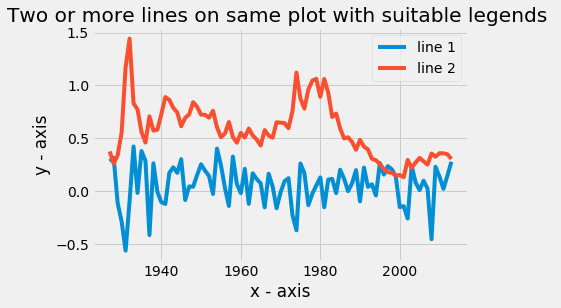

In [24]:
plt.plot(df["Year"], df["LogEqPrem"], label = "line 1")
plt.plot(df["Year"], df["BookMarket"], label = "line 2")
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Two or more lines on same plot with suitable legends ')
plt.legend()
plt.show()

In [0]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [0]:
# train, test = split_data(df, '1990')

X_train = df[df['Year'] < 1990][['Year','BookMarket']]
y_train = df[df['Year'] < 1990]['LogEqPrem']

X_test = df[df['Year'] >= 1990][['Year','BookMarket']]
y_test = df[df['Year'] >= 1990]['LogEqPrem']

In [48]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(63, 2)
(63,)
(24, 2)
(24,)


In [49]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[19:21:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = reg.predict(X_test)

In [54]:
reg.score(y_test, y_pred)

ValueError: ignored

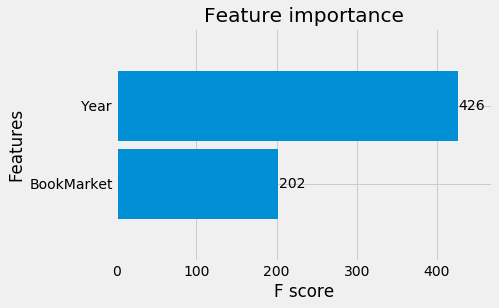

In [55]:
xgb.plot_importance(reg, height=0.9)

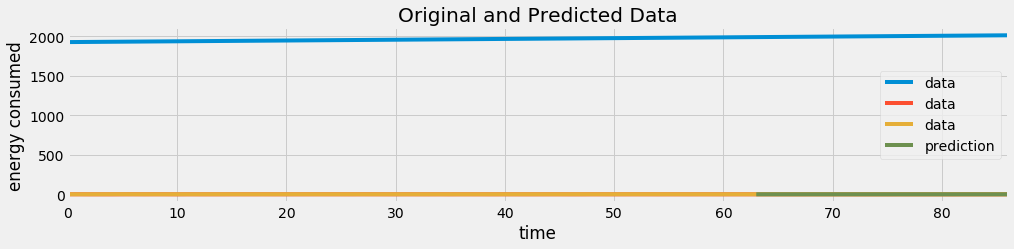

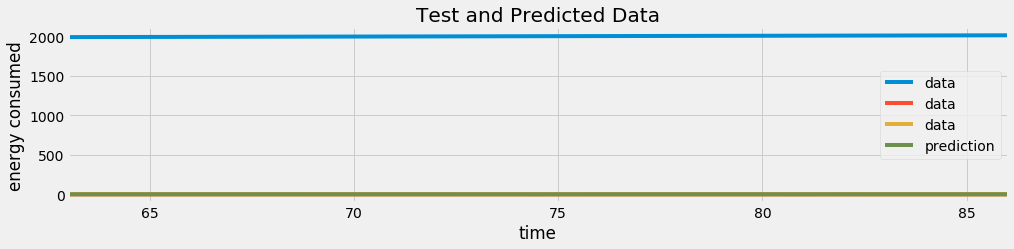

In [57]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(df.index, df, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)
X_test_pred = reg.predict(X_test)
    
plot_performance(df, df.index[0], df.index[-1],
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0], y_test.index[-1],
                 'Test and Predicted Data')

plt.legend()
plt.show()

In [58]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

0.03669708395220922

In [59]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

0.1389763007953135

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [61]:
mean_absolute_percentage_error(y_test,X_test_pred)

181.70561563889044